<a href="https://colab.research.google.com/github/sinheechan/API_TinyDB/blob/main/KAKAO_API_%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KAKAO API

## 1. Setting

### 1.1 Import library

In [1]:
import requests
from tqdm import tqdm
import time

### 1.2 Version check

In [2]:
!python --version

Python 3.10.12


## 2. KAKAO API Getting

KAKAO Developers 내 카카오 API는 카카오가 제공하는 오픈 API 및 플랫폼 서비스이다.

데이터 추출을 위해 Custom한 App 내 REST API 키를 사용한다.

자세한 링크는 아래를 참조한다.

- 카카오 API 키워드로 장소 검색: https://developers.kakao.com/docs/latest/ko/local/dev-guide#search-by-keyword

- 카카오 개발자 API 키 발급: https://developers.kakao.com

In [3]:
# 키워드로 장소 검색하기

app_key = 'KakaoAK ' + '5e344afdb788546b83962bf4c494083d'

url = 'https://dapi.kakao.com/v2/local/search/keyword.json'

## 3. Data Requests

KAKAO API를 활용해 치킨을 파는 음식점을 탐색한 결과를 요청하여 딕셔너리 향태로 반환받는다.

아울러 탐색하고자 하는 카테고리는 KAKAO 내 메뉴얼에 따른 키값을 입력하여야 한다.(하단 그림 참고)

In [21]:
# params
params = {
    'query': '냉면',
    'category_group_code': 'FD6',
    'page': 45
}

# headers
headers = {
    'Authorization': app_key
}

# 응답을 json으로 받고 list에 넣는다.
res = requests.get(url, params=params, headers=headers).json()

print(res.keys())

dict_keys(['documents', 'meta'])


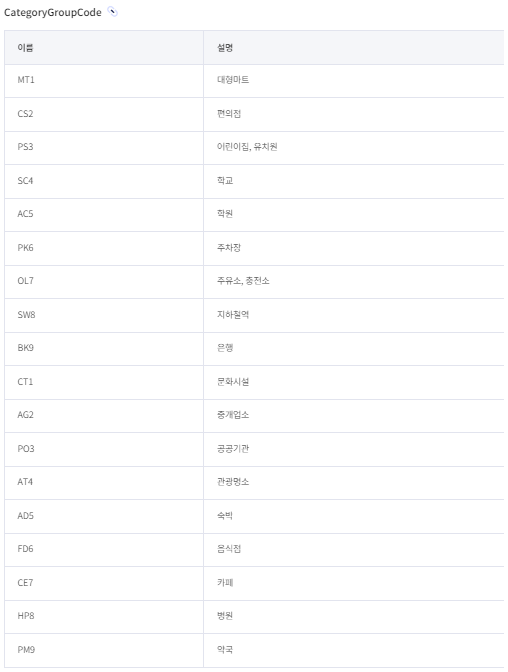

## 4. DATA EDA

res 변수에 받아온 딕셔너리 값을 체크한다.

In [22]:
search_count = res['meta']['total_count']

print(search_count)

38881


반환된 딕셔너리에서 documents를 찍어본다.

In [23]:
res['documents']

[{'address_name': '대전 중구 대흥동 188-5',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 한식 > 냉면',
  'distance': '',
  'id': '25049472',
  'phone': '042-256-6506',
  'place_name': '사리원면옥 본점',
  'place_url': 'http://place.map.kakao.com/25049472',
  'road_address_name': '대전 중구 중교로 62',
  'x': '127.426540617167',
  'y': '36.3261520899609'},
 {'address_name': '부산 중구 남포동2가 17-1',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 한식 > 냉면',
  'distance': '',
  'id': '11047533',
  'phone': '',
  'place_name': '오래된할매가야밀면',
  'place_url': 'http://place.map.kakao.com/11047533',
  'road_address_name': '부산 중구 광복로 56-14',
  'x': '129.031223043883',
  'y': '35.098946750334'},
 {'address_name': '서울 영등포구 영등포동3가 7-32',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 한식 > 냉면',
  'distance': '',
  'id': '10643743',
  'phone': '02-2678-2722',
  'place_name': '함흥냉면',
  'place_url': 'http:/

In [24]:
res['meta']

{'is_end': True,
 'pageable_count': 45,
 'same_name': {'keyword': '냉면', 'region': [], 'selected_region': ''},
 'total_count': 38881}

## 5. Map Search - Crawling

분할 검색
우리나라 지도를 위경도 0.25 단위의 작은 사각형으로 쪼개어 분할 검색한다.

상세페이지에서 가격 긁어오기 https://place.map.kakao.com/main/v/9847579

IP 차단 피하기 위해 5초 대기

DB 저장
place_name: 음식점 이름
menu: 메뉴 이름
price: 가격

In [ ]:
# 실행 x => 아주 오래걸림 대략 10시간
# 우리나라 지도를 아주 작은 단위로 나눠 전국에 있는 치킨집 주소를 전부 분석한다.

# 시작 좌표 설정
start_x = 126 # 126.0 - 130.0
start_y = 33 # 33.0 - 39.0

# x,y 증가량 설정
dx = 0.25
dy = 0.25

# tqdm 라이브러리를 사용하여 진행 상황을 시각화
# x 좌표(18), y 좌표(26) 반복
for i in tqdm(range(18)):
    for j in range(26):
        x = start_x + dx * i
        y = start_y + dy * j
        print(x, y)

        # API 요청에 필요한 매개변수를 설정
        for page in range(1, 46):
            params = {
                'query': '냉면',
                'page': page,
                'rect': f'{x},{y},{x + dx},{y + dy}'
            }

            # 카카오 맵 API에 GET 요청
            res = requests.get(url, params=params, headers=headers).json()

            # 결과가 없다면 내부 반복문을 종료
            if len(res['documents']) == 0:
                break

            for doc in res['documents']:
                place_name = doc['place_name']

                detail_url = f'https://place.map.kakao.com/main/v/{doc["id"]}'

                data = requests.get(detail_url, headers=headers).json()

                # 메뉴정보 중 가격만 우선적으로 가져온다.
                if 'menuInfo' not in data:
                    continue
                # 필터링
                menu_list = data['menuInfo']['menuList']

                # 가격이 0이면 replace 처리
                for menu_item in menu_list:
                    price = 0
                    if 'price' in menu_item:
                      try:
                        price = int(menu_item['price'].replace(',', ''))
                      except ValueError:

                      # 'price' 항목이 숫자가 아닌 경우 예외 처리
                          continue

                  # TinyDB에 음식 명, 메뉴, 가격을 집어넣는다.
                    db.insert({
                        'place_name': place_name,
                        'menu': menu_item['menu'],
                        'price': price
                    })

                time.sleep(5)

            if res['meta']['is_end']:
                break

## 6. Tiny DB

TinyDB는 파이썬으로 작성된 경량의 NoSQL 데이터베이스이다.

JSON 형식으로 데이터를 저장하며, 파일 기반의 데이터베이스로 동작한다.

앞서 크롤링 한 내용을 저장한 db.json 파일을 Tiny.db에 할당한다.

In [14]:
!pip install tinydb

from tinydb import TinyDB, Query

# db 변수에 json 파일 할당
db = TinyDB('/content/drive/MyDrive/Dataset/KAKAO_API/db.json.json')

In [21]:
# db에 테이블 하나, 56216행이 출력되었다.
db

<TinyDB tables=['_default'], tables_count=1, default_table_documents_count=56216, all_tables_documents_count=['_default=56216']>

## 7. Menu Search

In [ ]:
# 가격이 35,000원 초과하는 키워드 메뉴 검색
db.search(Query().price > 35000)

[{'place_name': '돌담너머바다 판포점', 'menu': '돔베 스테이크', 'price': 39000},
 {'place_name': '마담나탈리소셜클럽', 'menu': '글렌피딕 15Y', 'price': 250000},
 {'place_name': '인판포', 'menu': '바베큐 플레이터', 'price': 60000},
 {'place_name': '인판포', 'menu': '마라소라새우', 'price': 40000},
 {'place_name': '제마닭', 'menu': '닭도리탕(대)', 'price': 36000},
 {'place_name': '제마닭', 'menu': '꽃도리탕(중)', 'price': 38000},
 {'place_name': '제마닭', 'menu': '꽃도리탕(대)', 'price': 48000},
 {'place_name': '먹고정', 'menu': '백돼지한근반', 'price': 63000},
 {'place_name': '먹고정', 'menu': '백돼지한근', 'price': 42000},
 {'place_name': '먹고정', 'menu': '흑돼지한근반', 'price': 80000},
 {'place_name': '먹고정', 'menu': '흑돼지한근', 'price': 54000},
 {'place_name': '모루쿠다', 'menu': '모루쿠다 육합', 'price': 40000},
 {'place_name': '원조장수통닭', 'menu': '토종닭', 'price': 60000},
 {'place_name': '원조장수통닭', 'menu': '오리주물럭', 'price': 60000},
 {'place_name': '진솔통닭', 'menu': '토종닭(1마리)', 'price': 60000},
 {'place_name': '진솔통닭', 'menu': '오리(1마리)', 'price': 60000},
 {'place_name': '오름지미정원', 'menu': '찹스테이크 (3

가격이 35,000 초과 AND "치" 포함하는 메뉴를 검색한다.

두번 째 행은 187000원으로 수집에 오류가 있음을 의심할 수 있다.즉 이상치가 식별된다.

하지만 이상치가 있더라도 카카오에서 관리하는 DB이기 때문에 공신력이 있다고 판단한다.

이는 이후 데이터 분석 단계에서 전처리를 통한 필터링이 필요할 것으로 판단된다.

In [ ]:
db.search((Query().price > 35000) & (Query().menu.search('치')))

[{'place_name': '화덕에꾸운닭 전남담양점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '아웃닭 신촌역점', 'menu': '오리지날 레드핀 양념치킨', 'price': 187000},
 {'place_name': '누구나홀딱반한닭 홍대점', 'menu': '바사칸치빵파티', 'price': 36900},
 {'place_name': '크치치킨 경희대점', 'menu': '치킨세트D', 'price': 37000},
 {'place_name': '누구나홀딱반한닭 선릉점', 'menu': '바사칸치빵파티', 'price': 38900},
 {'place_name': '화덕에꾸운닭 강원홍천점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '화덕에꾸운닭 창원진동점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '앗싸마늘닭 본점', 'menu': '앗싸 스페셜 두마리 치찜세트', 'price': 37900}]

전국 치킨 평균 가격 탐색 ( 프랜차이즈를 모두 포함하여 정확한 가격은 아님을 유의한다. )

In [ ]:
chickens = db.search(Query().menu.search('치'))

prices = []

for chicken in chickens:
    prices.append(chicken['price'])

avg_price = sum(prices) / len(prices)

print('치킨 %d개의 평균 가격 : %.2f원' % (len(chickens), avg_price))

치킨 22673개의 평균 가격은 17762.06원 입니다


## 8. Data visualization

<Axes: ylabel='Count'>

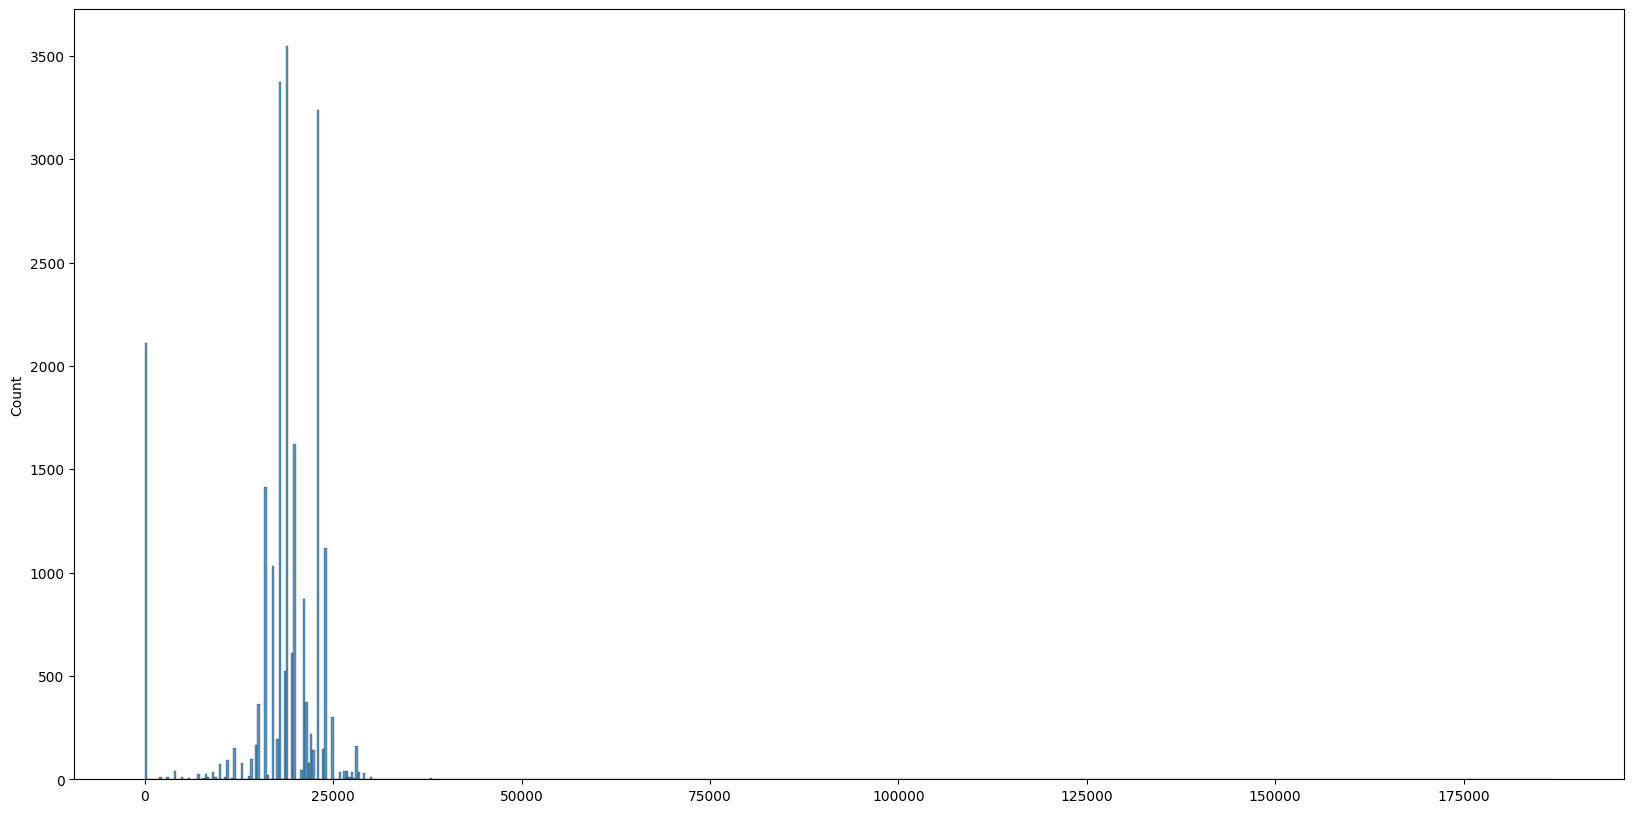

In [ ]:
# 가격 분포 그래프
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x = prices, ax = ax)